In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from pathlib import Path
from typing import Tuple

BATCH_SIZE  = 500
EPOCHS      = 10          
LR          = 1e-1
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load MNIST using Keras
print("Loading the MNIST dataset")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def resize_and_normalize(vec28: np.ndarray) -> np.ndarray:
    """Down-sample 28×28 → 8×8, flatten to length-64, ℓ2-normalize."""
    img = vec28.reshape(28, 28)
    img8 = resize(img, (8, 8), anti_aliasing=True)
    flat = img8.flatten()
    norm = np.linalg.norm(flat) + 1e-10
    return flat / norm
  

def to_density(vec64: np.ndarray) -> np.ndarray:
    """|ψ⟩⟨ψ| to get 64×64 Hermitian rank-1 density matrix."""
    return np.outer(vec64, vec64.conjugate())


def build_dataset(images,labels):
    vectors = np.stack([resize_and_normalize(im) for im in images])
    density = np.stack([to_density(v) for v in vectors])
    return density, labels

class HermitianDataset(Dataset):
    def __init__(self, mats: np.ndarray, labels: np.ndarray):
        self.mats = torch.tensor(mats, dtype=torch.complex64)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self): return len(self.mats)
    def __getitem__(self, idx):
        return self.mats[idx], self.labels[idx]


class MatrixModel(nn.Module):
    def __init__(self, num_classes=10, dim=64):
        super().__init__()
        self.dim = dim
        self.num_classes = num_classes
        self.gen_real = nn.Parameter(torch.randn(num_classes, dim, dim))
        self.gen_imag = nn.Parameter(torch.randn(num_classes, dim, dim))
        self.eigvals   = nn.Parameter(torch.randn(num_classes, dim))

    def _unitary(self, gen_r, gen_i):
        g = torch.complex(gen_r, gen_i)
        herm = (g + g.conj().transpose(-2, -1)) / 2
        return torch.matrix_exp(-1j * herm)

    def hamiltonians(self):
        U = self._unitary(self.gen_real, self.gen_imag)           
        D = torch.diag_embed(torch.complex(self.eigvals, torch.zeros_like(self.eigvals)))
        H = U @ D @ U.conj().transpose(-2, -1)                 
        return (H + H.conj().transpose(-2, -1)) / 2                

    def forward(self):                                         
        return self.hamiltonians()


def prototype_loss(protos, batch_mats, labels):
    B = batch_mats.size(0)
    target = protos[labels]                                
    return torch.linalg.norm(batch_mats - target, dim=(1, 2)).mean()

def train_model(model, loader):
    opt = optim.Adam(model.parameters(), lr=LR)
    lr_sched = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.5)

    for epoch in range(EPOCHS):
        print(f"Epoch: {epoch}")
        model.train()
        running = 0
        for mats, lbl in loader:
            mats, lbl = mats.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            loss = prototype_loss(model.hamiltonians(), mats, lbl)
            loss.backward()
            opt.step()
            running += loss.item()
        avg = running / len(loader)
        lr_sched.step(avg)
        print(f"Epoch {epoch+1:02d}/{EPOCHS}  •  loss {avg:.6f}")

    return model.hamiltonians().detach().cpu().numpy()


print("Preparing data")
train_mats, train_labels = build_dataset(x_train, y_train)

print(f"Class distribution: {np.bincount(train_labels)}")
ds = HermitianDataset(train_mats,train_labels)
dl = DataLoader(ds,batch_size = BATCH_SIZE, shuffle = True)

print("Training...")
model = MatrixModel().to(DEVICE)
hams = train_model(model,dl)

for k in range(10):
    herm = np.allclose(hams[k], hams[k].conj().T)
    frob = np.linalg.norm(hams[k])
    print(f"Class {k}: Hermitian={herm}, Frobenius norm={frob:.4f}")

2025-08-16 14:16:39.815276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755353800.178905      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755353800.278510      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading the MNIST dataset
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Preparing data
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Training...
Epoch: 0
Epoch 01/10  •  loss 1.176698
Epoch: 1
Epoch 02/10  •  loss 0.648377
Epoch: 2
Epoch 03/10  •  loss 0.639531
Epoch: 3
Epoch 04/10  •  loss 0.636800
Epoch: 4
Epoch 05/10  •  loss 0.633991
Epoch: 5
Epoch 06/10  •  loss 0.636086
Epoch: 6
Epoch 07/10  •  loss 0.632726
Epoch: 7
Epoch 08/10  •  loss 0.632344
Epoch: 8
Epoch 09/10  •  loss 0.631264
Epoch: 9
Epoch 10/10  •  loss 0.632193
Class 0: Hermitian=True, Frobenius norm=0.8020
Class 1: Hermitian=True, Frobenius norm=0.8182
Class 2: Hermitian=True, Frobenius norm=0.7549
Class 3: Hermitian=True, Frobenius norm=0.8111
Class 4: Hermitian=True, Frobenius norm=0.7473
Class 5: Hermitian=True, Frobenius norm=0.7119
Class 6: Hermitian=True, Frobenius norm=0.7974
Class 7: Hermitian=True, Frobenius norm=0.7987
Class 8: Hermitian=True, Frobenius norm=0.8345
Class 9: He

In [3]:
# ML Gradient Pipeline Finding the Quantum Harmonic Oscillator Hamiltonian Truncated to 64 levels for MNIST Dataset...

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class SharedHamiltonian(nn.Module):
    def __init__(self, N, m=1.0, omega=1.0, hbar=1.0):
        super().__init__()
        self.xcap = nn.Parameter(torch.randn(N, N, dtype=torch.complex128) * 1e-2)
        self.pcap = nn.Parameter(torch.randn(N, N, dtype=torch.complex128) * 1e-2)
        self.m = torch.tensor(m, dtype=torch.complex128)
        self.omega = torch.tensor(omega, dtype=torch.complex128)
        self.hbar = torch.tensor(hbar, dtype=torch.complex128)

    def forward(self):
        x = (self.xcap + self.xcap.conj().T) * 0.5
        p = (self.pcap + self.pcap.conj().T) * 0.5
        H = (p @ p.conj().T) / (2 * self.m) + 0.5 * self.m * (self.omega**2) * (x @ x.conj().T)
        return H

    def commutator_constraint(self):
        x = (self.xcap + self.xcap.conj().T) * 0.5
        p = (self.pcap + self.pcap.conj().T) * 0.5
        I = torch.eye(x.shape[0], dtype=torch.complex128, device=x.device)
        comm = x @ p - p @ x
        target = 1j * self.hbar * I
        return torch.mean(torch.abs(comm - target)**2)


def train_shared_parameters(hamiltonians, num_epochs_stage1=500, num_epochs_stage2=500,
                            lr=1e-4, comm_weight_stage1=1e5, comm_weight_stage2=1e4,
                            recon_weight=1.0, spectral_alpha=1.0, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    targets = [torch.tensor(h, dtype=torch.complex128, device=device) for h in hamiltonians]
    N =  64

    model = SharedHamiltonian(N).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    def step(epoch, comm_w, recon_w):
        optimizer.zero_grad()
        H_pred = model()
        recon_real = sum(F.mse_loss(H_pred.real, H_t.real) for H_t in targets)
        recon_imag = sum(F.mse_loss(H_pred.imag, H_t.imag) for H_t in targets)
        recon_loss = recon_real + recon_imag
        comm_loss = model.commutator_constraint()
        loss = comm_w * comm_loss + recon_w * recon_loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | CommLoss={comm_loss.item():.2e} | ReconLoss={recon_loss.item():.2e}")

    # Stage 1: commutator Loss redcution
    for epoch in range(1, num_epochs_stage1 + 1):
        step(epoch, comm_weight_stage1, 0.0)

    # Stage 2: Fine-tune reconstruction of the parameters obtained from stage 1
    for epoch in range(1, num_epochs_stage2 + 1):
        step(epoch, comm_weight_stage2, recon_weight)

    xcap_np = model.xcap.detach().cpu().numpy()
    pcap_np = model.pcap.detach().cpu().numpy()
    H_shared_np = model().detach().cpu().numpy()
    mass_np = model.m.detach().cpu().numpy()
    hbar_np = model.hbar.detach().cpu().numpy()
    omega_np = model.omega.detach().cpu().numpy()
    return xcap_np, pcap_np, H_shared_np , mass_np , hbar_np , omega_np

targets = hams

xcap, pcap, H_shared , mass_np , hbar_np , omega_np = train_shared_parameters(
        targets,
        num_epochs_stage1=100,
        num_epochs_stage2=100,
        lr=1e-4,
        comm_weight_stage1=1,
        comm_weight_stage2=1,
        recon_weight=1.0,
        spectral_alpha=1.0
    )

Epoch    1 | CommLoss=1.56e-02 | ReconLoss=1.50e-03
Epoch   50 | CommLoss=1.56e-02 | ReconLoss=1.50e-03
Epoch  100 | CommLoss=1.56e-02 | ReconLoss=1.50e-03
Epoch    1 | CommLoss=1.56e-02 | ReconLoss=1.50e-03
Epoch   50 | CommLoss=1.56e-02 | ReconLoss=1.39e-03
Epoch  100 | CommLoss=1.56e-02 | ReconLoss=1.36e-03


In [4]:
#Here xcap and pcap parameter are truncated upto 64 levels and hence they do not satisfy the commutative constraint in finite level case
# Commutative Relation in Finite Level Case not equal to i*I
x = (xcap + xcap.conj().T) * 0.5
p = (pcap + pcap.conj().T) * 0.5
commutator = x @ p - p @ x
print(np.trace(commutator)) # not equal to 64*i # Mathematical Limit for truncation...
print(hams.shape)

-3.469446951953614e-18j
(10, 64, 64)


In [5]:
# Imposing Hermitian Constraints on the Position and the Momentum Operators if not already satisfied -
m , omega = mass_np , omega_np
H_QHO_MNIST = (p @ p.conj().T) / (2 * m) + 0.5 * m * (omega**2) * (x @ x.conj().T)

# Plot of Quantum Harmonic Oscillator for MNIST for 6 levels i.e. 64 x 64 Hamiltonian Matrix ...

# Energy Eigen Values and Energy Eigen States (Eigen Vectors)

eig_fn = np.linalg.eigh

energyeigenvalues, energyeigenvectors = eig_fn(H_QHO_MNIST)
Energy_Eigen_States = energyeigenvectors
Energy_Eigen_States_conj_T = energyeigenvectors.T.conj() 
Energy_Eigen_Values = energyeigenvalues

# Position Eigen Values and Position Eigen States (Eigen Vectors)

positioneigenvalues, positioneigenvectors = eig_fn(x)
Position_Eigen_States = positioneigenvectors
Position_Eigen_States_conj_T = positioneigenvectors.T.conj() 
Position_Eigen_Values = positioneigenvalues

Plot for Non-Normalized case

In [ ]:
#Visualizing quantum states by plotting probability amplitudes of eigenstates of a hamiltonian against position x and energy E.
#After diagonalising the Hamiltonian H, we get energy levels as eigenvalues and wavefunctions in energy basis as eigenvectors
#


# Non - Normalized Visualization of the Probability Amplitudes...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import os

def plot_quantum_states_comprehensive(E_vals, E_vecs, X_vals, X_vecs):
    nE, nX = len(E_vals), len(X_vals)
    # Non-Normalized Probabilities per energy Level
    amps = np.abs(E_vecs.conj().T @ X_vecs) ** 2
    # Normalized Probability Amplitudes per energy level
    # Uncomment for Normalized Case
    # amps_raw = np.abs(E_vecs.conj().T @ X_vecs) ** 2  # shape (nE, nX)

    # # Normalize each energy row by its RMS (root sum of squares)
    # rms = np.sqrt(np.sum(amps_raw**2, axis=1, keepdims=True))  # shape (nE, 1)
    # amps = amps_raw / rms

    cmap_pieces = [
        plt.cm.tab20(np.linspace(0, 1, 20)),
        plt.cm.Set3(np.linspace(0, 1, 12)),
        plt.cm.Dark2(np.linspace(0, 1, 8)),
        plt.cm.Accent(np.linspace(0, 1, 8)),
        plt.cm.Paired(np.linspace(0, 1, 12)),
        plt.cm.Set1(np.linspace(0, 1, 4)),
    ]
    colors = np.vstack(cmap_pieces)[:nE]

    def envelope(xv, yv, a):
        pts = [
            (xv[i], yv[np.argmax(a[:, i])])
            for i in range(len(xv))
            if a[:, i].max() > 1e-3
        ]
        if len(pts) < 5:
            return None, None
        pts.sort(key=lambda p: p[0])
        xs, ys = zip(*pts)
        spline = UnivariateSpline(xs, ys, s=len(xs) * 0.1)
        xsmooth = np.linspace(xs[0], xs[-1], 300)
        return xsmooth, spline(xsmooth)

    def plot_panel(ax, zx, zy, title, version, legend_full=False):
        for E in E_vals:
            ax.axhline(E, color='lightgray', lw=0.5, alpha=0.3)
        if version == 1:
            for k, E in enumerate(E_vals):
                c = amps[k]
                ax.scatter(X_vals, np.full(nX, E), c=c, cmap='plasma',
                           s=c * 1200, edgecolors='black', lw=0.4, alpha=0.7)
            cb = plt.colorbar(ax.collections[-1], ax=ax, shrink=0.8)
            cb.set_label('|⟨x|ψ⟩|²')
        else:
            handles = []
            for k, E in enumerate(E_vals):
                sz = amps[k] * 700
                ax.scatter(X_vals, np.full(nX, E), color=colors[k], s=sz,
                           edgecolors='black', lw=0.3, alpha=0.8)
                if legend_full:
                    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                              markerfacecolor=colors[k], markersize=6,
                                              label=f'ψ_{k}: E={E:.3f}'))
        xv, yv = envelope(X_vals, E_vals, amps)
        if xv is not None:
            ax.plot(xv, yv, 'r--', lw=2, label='V(x) envelope')
            if legend_full:
                handles.append(plt.Line2D([0], [0], color='red', linestyle='--',
                                          lw=2, label='V(x) envelope'))
        if zx:
            ax.set_xlim(*zx)
        if zy:
            ax.set_ylim(*zy)
        ax.set_xlabel('x')
        ax.set_ylabel('E')
        ax.set_title(title, fontweight='bold')
        ax.grid(alpha=0.3)
        if legend_full:
            ax.legend(handles=handles, bbox_to_anchor=(1.02, 1),
                      loc='upper left', fontsize=7, ncol=4,
                      title='All 64 Energy Levels')
        
        plt.savefig(title, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Saved: {title}")
    Emin, Emax = E_vals.min(), E_vals.max()
    xmin, xmax = X_vals.min(), X_vals.max()
    dE, dX = Emax - Emin, xmax - xmin

    views = [
        (None, None, "Full Range – Plasma Colormap", 1, False),
        (None, None, "Full Range – 64-Level Colors + Legend", 2, True),
        None,  # blank slot
        (None, (Emin, Emin + 0.20 * dE), "Lowest 20% Energies", 2, False),
        (None, (Emin, Emin + 0.10 * dE), "Lowest 10% Energies", 2, False),
        ((-0.2, 0.2), (Emin, Emin + 0.05 * dE), "Lowest 5% Energies", 2, False),
        ((-0.2, 0.2), (Emin, Emin + 0.02 * dE), "Lowest 2% Energies", 2, False),
        ((-0.125, 0.125), (Emin, Emin + 0.01 * dE), "Lowest 1% Energies", 2, False),
        ((xmin + 0.45 * dX, xmax - 0.45 * dX), None, "x≈0 Central 10%", 2, False)
    ]

    rows = (len(views) + 2) // 3
    fig = plt.figure(figsize=(24, 6 * rows))
    outer = GridSpec(rows, 1, height_ratios=[1] * rows, hspace=0.3)

    for r in range(rows):
        if r == 0:
            inner = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[r],
                                            width_ratios=[1, 0.6, 1], wspace=0.12)
        else:
            inner = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[r],
                                            width_ratios=[1, 1, 1], wspace=0.15)
        for c in range(3):
            idx = r * 3 + c
            if idx >= len(views):
                break
            slot = views[idx]
            ax = fig.add_subplot(inner[0, c])
            if slot is not None:
                zx, zy, title, ver, leg = slot
                plot_panel(ax, zx, zy, title, ver, leg)
            else:
                ax.axis('off')

    fig.suptitle('Quantum States Probabilities E vs x: |⟨x|ψ⟩|² with V(x) Envelope (64 Levels)',
                 fontsize=18, fontweight='bold', y=0.94)
    plt.show()
    return fig


def main():
    eig = np.linalg.eigh
    E_vals, E_vecs = eig(H_QHO_MNIST)
    X_vals, X_vecs = eig(x)
    plot_quantum_states_comprehensive(E_vals, E_vecs, X_vals, X_vecs)


if __name__ == "__main__":
    main()


Plots for Normalised case

Saved: Lowest 10% Energies+norm


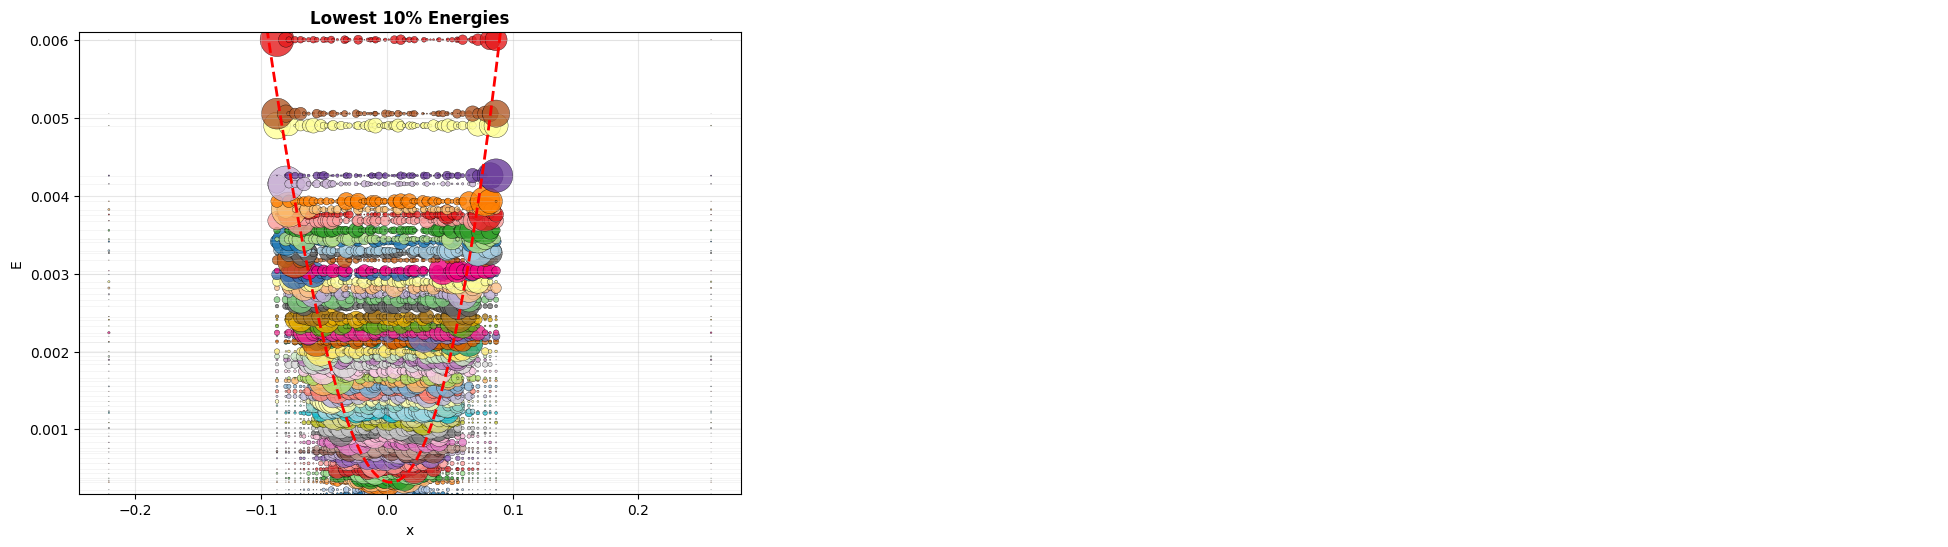

In [10]:
# Normalized Visualization of the Probability Amplitudes...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_quantum_states_comprehensive(E_vals, E_vecs, X_vals, X_vecs):
    nE, nX = len(E_vals), len(X_vals)
    amps_raw = np.abs(E_vecs.conj().T @ X_vecs) ** 2  
    rms = np.sqrt(np.sum(amps_raw**2, axis=1, keepdims=True)) 
    amps = amps_raw / rms
    cmap_pieces = [
        plt.cm.tab20(np.linspace(0, 1, 20)),
        plt.cm.Set3(np.linspace(0, 1, 12)),
        plt.cm.Dark2(np.linspace(0, 1, 8)),
        plt.cm.Accent(np.linspace(0, 1, 8)),
        plt.cm.Paired(np.linspace(0, 1, 12)),
        plt.cm.Set1(np.linspace(0, 1, 4)),
    ]
    colors = np.vstack(cmap_pieces)[:nE]

    def envelope(xv, yv, a):
        pts = [
            (xv[i], yv[np.argmax(a[:, i])])
            for i in range(len(xv))
            if a[:, i].max() > 1e-3
        ]
        if len(pts) < 5:
            return None, None
        pts.sort(key=lambda p: p[0])
        xs, ys = zip(*pts)
        spline = UnivariateSpline(xs, ys, s=len(xs) * 0.1)
        xsmooth = np.linspace(xs[0], xs[-1], 300)
        return xsmooth, spline(xsmooth)

    def plot_panel(ax, zx, zy, title, version, legend_full=False):
        for E in E_vals:
            ax.axhline(E, color='lightgray', lw=0.5, alpha=0.3)

        # Scatter points
        if version == 1:
            # Plasma colormap by normalized amplitude
            for k, E in enumerate(E_vals):
                c = amps[k]
                ax.scatter(X_vals, np.full(nX, E),
                           c=c, cmap='plasma',
                           s=c * 1200,
                           edgecolors='black', lw=0.4, alpha=0.7)
            cb = plt.colorbar(ax.collections[-1], ax=ax, shrink=0.8)
            cb.set_label('|⟨x|ψ⟩|² (normalized)', fontsize=10)
        else:
            handles = []
            for k, E in enumerate(E_vals):
                sz = amps[k] * 700
                ax.scatter(X_vals, np.full(nX, E),
                           color=colors[k], s=sz,
                           edgecolors='black', lw=0.3, alpha=0.8)
                if legend_full:
                    handles.append(
                        plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=colors[k], markersize=6,
                                   label=f'ψ_{k}: E={E:.3f}')
                    )

        # Envelope V(x)
        xv, yv = envelope(X_vals, E_vals, amps)
        if xv is not None:
            ax.plot(xv, yv, 'r--', lw=2, label='V(x) envelope')
            if legend_full:
                handles.append(
                    plt.Line2D([0], [0], color='red', linestyle='--',
                               lw=2, label='V(x) envelope')
                )

        # Apply zoom limits
        if zx:
            ax.set_xlim(*zx)
        if zy:
            ax.set_ylim(*zy)

        # Labels and title
        ax.set_xlabel('x')
        ax.set_ylabel('E')
        ax.set_title(title, fontweight='bold')
        ax.grid(alpha=0.3)

        # Legend for center plot
        if legend_full:
            ax.legend(handles=handles, bbox_to_anchor=(1.02, 1),
                      loc='upper left', fontsize=7, ncol=4,
                      title='All 64 Energy Levels', title_fontsize=9)

        plt.savefig(f"/kaggle/working/{title}_norm.png", dpi=300, bbox_inches="tight")
        print(f"Saved: {title}+norm")
        

    # Compute ranges
    Emin, Emax = E_vals.min(), E_vals.max()
    xmin, xmax = X_vals.min(), X_vals.max()
    dE, dX = Emax - Emin, xmax - xmin

    # View configurations
    # views = [
    #     (None, None, "Full Range – Plasma Colormap", 1, False),
    #     (None, None, "Full Range – 64-Level Colors + Legend", 2, True),
    #     None,  # blank slot
    #     (None, (Emin, Emin + 0.20 * dE), "Lowest 20% Energies", 2, False),
    #     (None, (Emin, Emin + 0.10 * dE), "Lowest 10% Energies", 2, False),
    #     ((-0.2, 0.2), (Emin, Emin + 0.05 * dE), "Lowest 5% Energies", 2, False),
    #     ((-0.2, 0.2), (Emin, Emin + 0.02 * dE), "Lowest 2% Energies", 2, False),
    #     ((-0.1, 0.1), (Emin, Emin + 0.01 * dE), "Lowest 1% Energies", 2, False),
    #     ((xmin + 0.45 * dX, xmax - 0.45 * dX), None, "x≈0 Central 10%", 2, False),
    # ]
    views = [
        (None, (Emin, Emin + 0.10 * dE), "Lowest 10% Energies", 2, False)
    ]  

    rows = (len(views) + 2) // 3
    fig = plt.figure(figsize=(24, 6 * rows))
    outer = GridSpec(rows, 1, height_ratios=[1] * rows, hspace=0.3)

    for r in range(rows):
        if r == 0:
            inner = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[r],
                                            width_ratios=[1, 0.6, 1], wspace=0.12)
        else:
            inner = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[r],
                                            width_ratios=[1, 1, 1], wspace=0.15)
        for c in range(3):
            idx = r * 3 + c
            ax = fig.add_subplot(inner[0, c])
            slot = views[idx] if idx < len(views) else None
            if slot:
                zx, zy, title, version, legend_full = slot
                plot_panel(ax, zx, zy, title, version, legend_full)
            else:
                ax.axis('off')

    # fig.suptitle('Quantum States Probabilities E vs x: |⟨x|ψ⟩|² with V(x) Envelope (64 Levels)',
    #              fontsize=18, fontweight='bold', y=0.94)
    plt.show()
    return fig

def main():
    eig = np.linalg.eigh
    E_vals, E_vecs = eig(H_QHO_MNIST)
    X_vals, X_vecs = eig(x)
    plot_quantum_states_comprehensive(E_vals, E_vecs, X_vals, X_vecs)

if __name__ == "__main__":
    main()

# The Univariate Spline Can be made better (red line V(x)) fit , by passing it through extremums of the x per energy level where the |⟨x|ψ⟩|² is non zero .


In [1]:
!kaggle kernels output sohamnileshvaze/plots -p /path/to/dest

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
